**by: Valeria Viridiana Pineda Romero**

A01154500

# Analyze the Google Mobility Report of Mexico

## Data Understanding and Preparation

### Initial Data Analysis

In [1]:
import pandas as pd
from matplotlib import pyplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from math import sqrt
from sklearn.metrics import mean_squared_error


In [2]:
series = pd.read_csv('2020_MX_Region_Mobility_Report.csv', header=0, index_col=0)
del series['sub_region_2'] # Same value for all instances
del series['metro_area'] # all missing data
del series['census_fips_code'] # all missing data
del series['country_region'] # all missing data
del series['iso_3166_2_code']

In [3]:
series.describe()

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
count,9141.000000,9141.000000,9141.000000,8981.000000,9141.000000,9141.000000
mean,-35.836561,-11.942457,-33.865551,-36.808819,-24.892244,12.287605
std,17.883784,10.646250,17.450316,19.748865,18.604407,6.888538
min,-90.000000,-86.000000,-87.000000,-90.000000,-81.000000,-5.000000
25%,-48.000000,-18.000000,-45.000000,-50.000000,-38.000000,9.000000
50%,-35.000000,-11.000000,-36.000000,-39.000000,-29.000000,13.000000
75%,-28.000000,-5.000000,-27.000000,-28.000000,-10.000000,17.000000
max,23.000000,24.000000,61.000000,31.000000,22.000000,39.000000


In [4]:
series.describe(include=[object])

,sub_region_1,date
count,8864,9141
unique,32,277
top,Sinaloa,2020-03-21
freq,277,33


### Data Engineering

Set 'Date' as Index

In [5]:
#tdi = pd.DatetimeIndex(series.date)
#series.set_index(tdi, inplace=True)
#series.drop(columns='date', inplace=True)
#series.index.name = 'datetimeindex'

In [6]:
series['date'] = pd.to_datetime(series['date']).dt.strftime('%d/%m/%Y')

In [7]:
series.set_index('date', inplace=True)

### Missing Data

In [8]:
# use autocorrelation

In [9]:
pd.DataFrame(series.isnull().sum()/len(series)*100,columns=["NA"])

,NA
sub_region_1,3.030303
retail_and_recreation_percent_change_from_baseline,0.000000
grocery_and_pharmacy_percent_change_from_baseline,0.000000
parks_percent_change_from_baseline,0.000000
transit_stations_percent_change_from_baseline,1.750356
workplaces_percent_change_from_baseline,0.000000
residential_percent_change_from_baseline,0.000000


Percent of Total Missing Values

In [10]:
len(series[series.isnull().any(axis=1)])/len(series)*100

4.78065857127229

Replace NA in 'sub_region_1' with 'National Level'

In [11]:
series['sub_region_1'] = series['sub_region_1'].fillna('National Level')

Interpolate 'transit_stations_percent_change_from_baseline'

In [12]:
series['transit_stations_percent_change_from_baseline'] = series['transit_stations_percent_change_from_baseline'].interpolate()


Total Missing Values

In [13]:
len(series[series.isnull().any(axis=1)])/len(series)

0.0

# (5 pts) How are the 6 mobility indicators related with each other?

### i. Are they directly or indirectly related?

### ii. Which of them move similarly?

#### Pearson Correlation

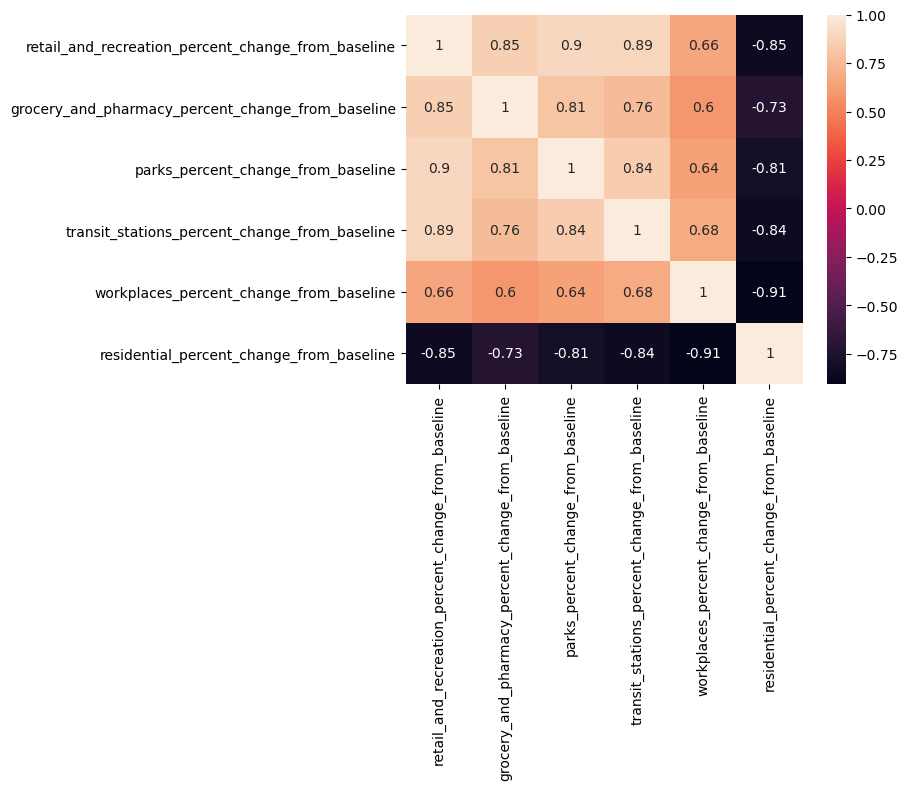

In [14]:
import seaborn as sn
corrMatrix = series.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

Scipy computed Pearson r: 0.8544738310192043 and p-value: 0.0


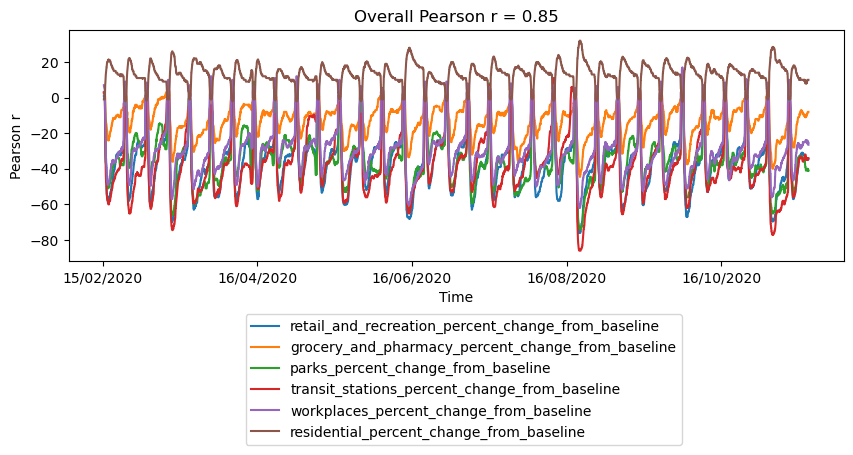

In [15]:
overall_pearson_r = series.corr().iloc[0,1]
r, p = stats.pearsonr(series.dropna()['retail_and_recreation_percent_change_from_baseline'], series.dropna()['grocery_and_pharmacy_percent_change_from_baseline'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(10,3))
series.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");
plt.legend(bbox_to_anchor = (0.8, -0.20))


plt.show()

# (5 pts) Analyze and discuss the characteristics of the 6 mobility indicators in Mexico.

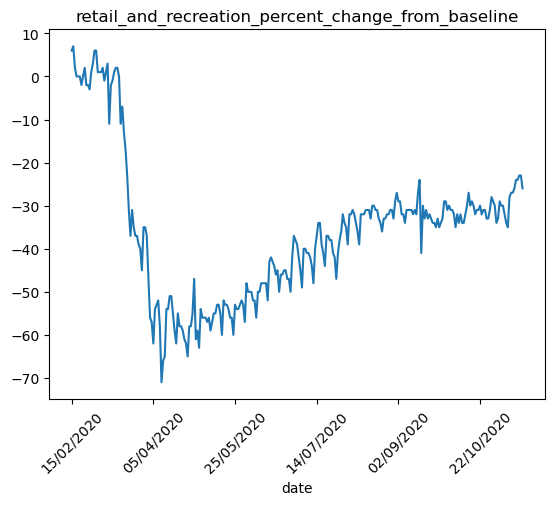

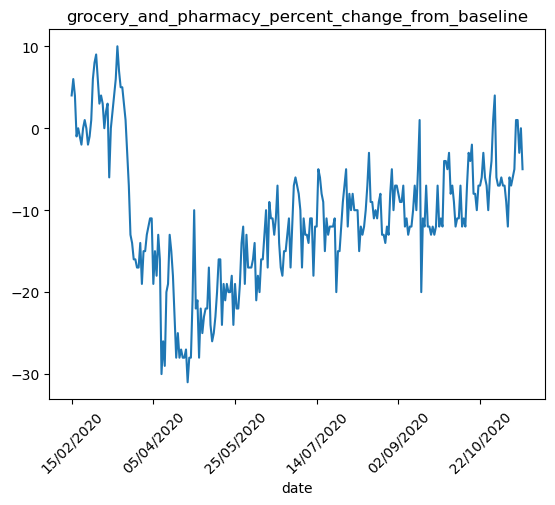

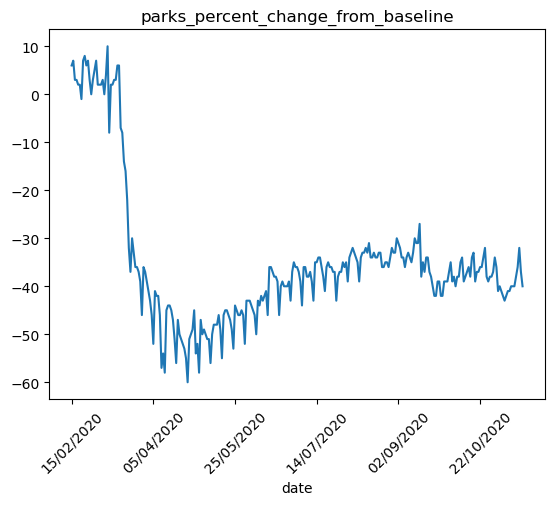

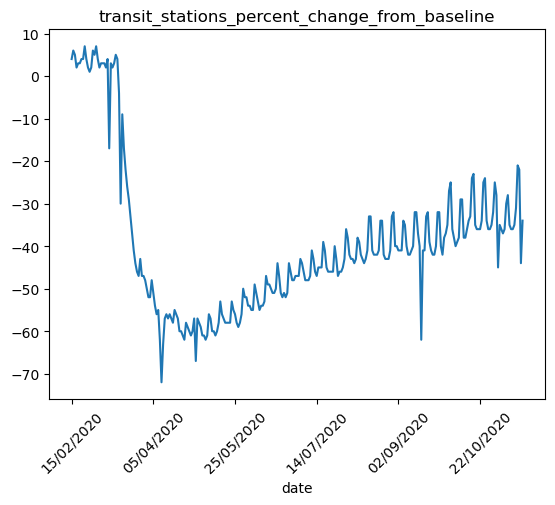

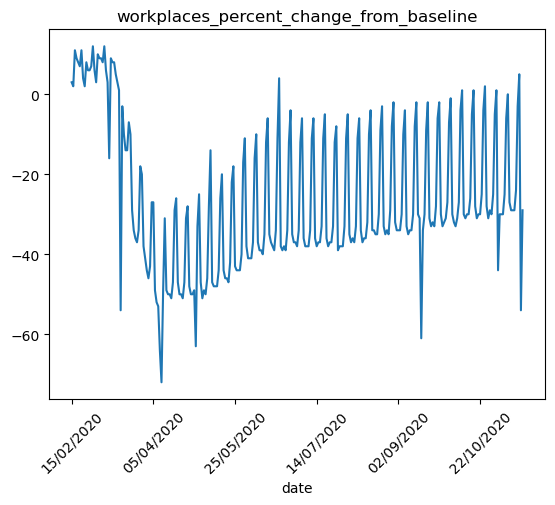

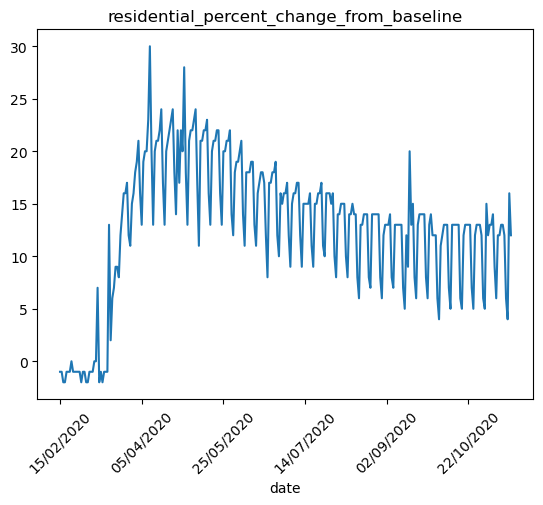

In [16]:
data = series[series['sub_region_1']=='National Level']
for i in data.columns:
    if i != 'sub_region_1':
        data[i].plot()
        plt.title(i)
        plt.xticks(rotation = 45)
        plt.show()

### i. Do you observe trend and seasonality?

In [17]:
data=series[series['sub_region_1']== 'National Level']

############################# retail_and_recreation_percent_change_from_baseline ##############################


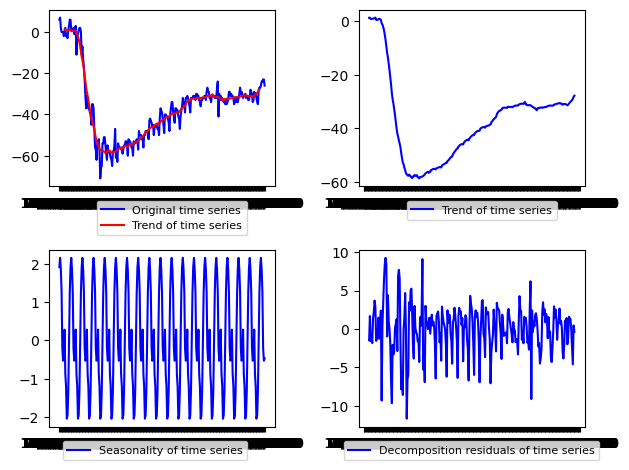

############################# grocery_and_pharmacy_percent_change_from_baseline ##############################


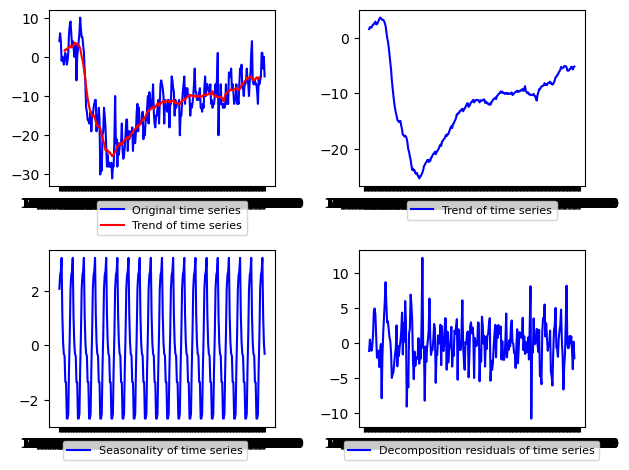

############################# parks_percent_change_from_baseline ##############################


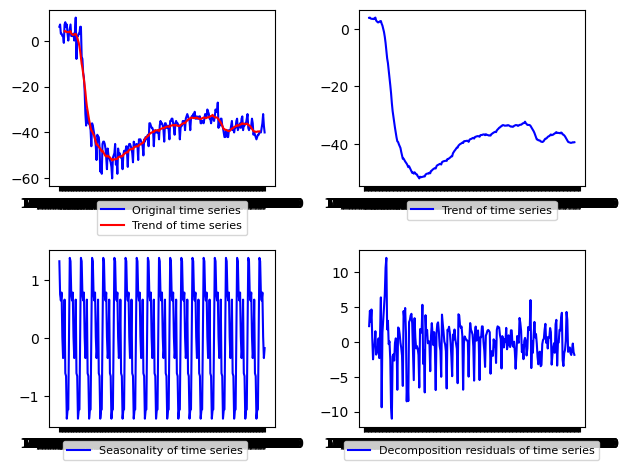

############################# transit_stations_percent_change_from_baseline ##############################


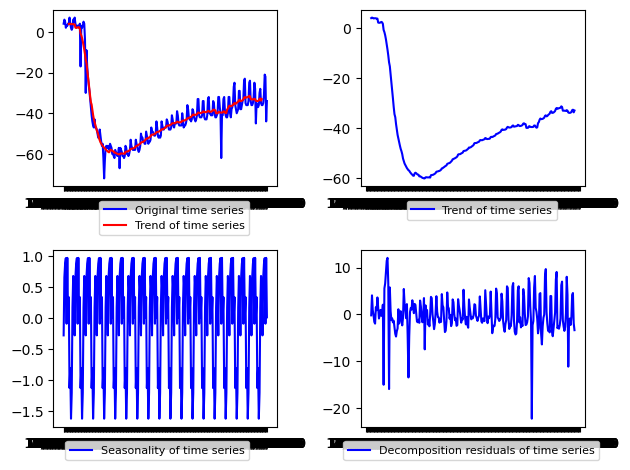

############################# workplaces_percent_change_from_baseline ##############################


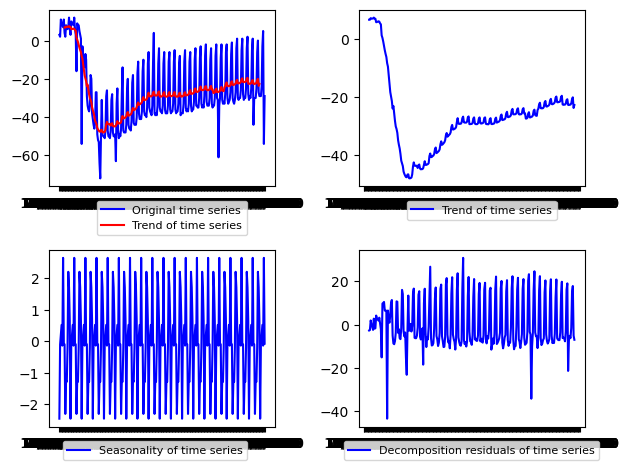

############################# residential_percent_change_from_baseline ##############################


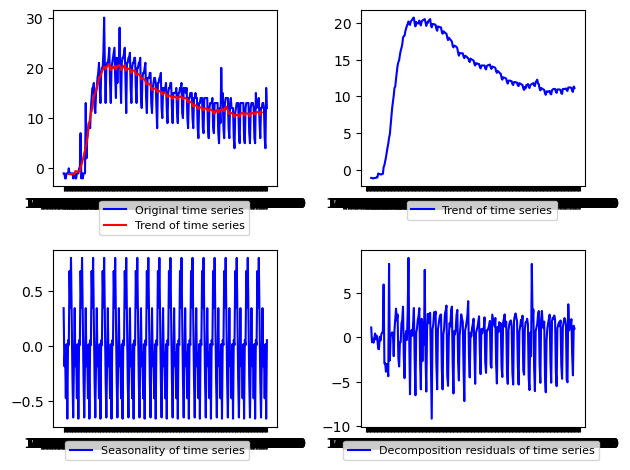

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
for i in data.columns:
    if i != 'sub_region_1': 
        decomposition = seasonal_decompose(data[i], period=15)
        trend_estimate = decomposition.trend
        periodic_estimate = decomposition.seasonal
        residual = decomposition.resid
        print(f'############################# {i} ##############################')
        plt.subplot(221)
        plt.plot(data[i],label='Original time series', color='blue')
        plt.plot(trend_estimate ,label='Trend of time series' , color='red')
        plt.legend(loc='best',fontsize=8 , bbox_to_anchor=(0.90, -0.05))
        plt.subplot(222)
        plt.plot(trend_estimate,label='Trend of time series',color='blue')
        plt.legend(loc='best',fontsize=8, bbox_to_anchor=(0.90, -0.05))
        plt.subplot(223)
        plt.plot(periodic_estimate,label='Seasonality of time series',color='blue')
        plt.legend(loc='best',fontsize=8, bbox_to_anchor=(0.90, -0.05))
        plt.subplot(224)
        plt.plot(residual,label='Decomposition residuals of time series',color='blue')
        plt.legend(loc='best',fontsize=8, bbox_to_anchor=(1.09, -0.05))
        plt.tight_layout()
        
        plt.show()

### ii. Are they stationary?

In [19]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(14).mean() #pd.rolling_mean(timeseries, window=12)
    rolstd = timeseries.rolling(14).std() #pd.rolling_std(timeseries, window=12)
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

retail_and_recreation_percent_change_from_baseline


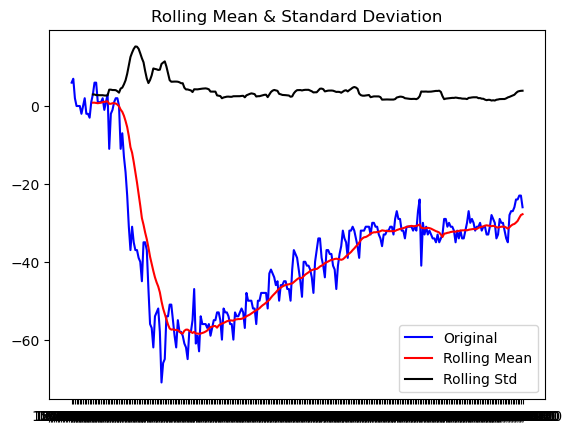

Results of Dickey-Fuller Test:
Test Statistic                  -3.117781
p-value                          0.025265
#Lags Used                      16.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64
grocery_and_pharmacy_percent_change_from_baseline


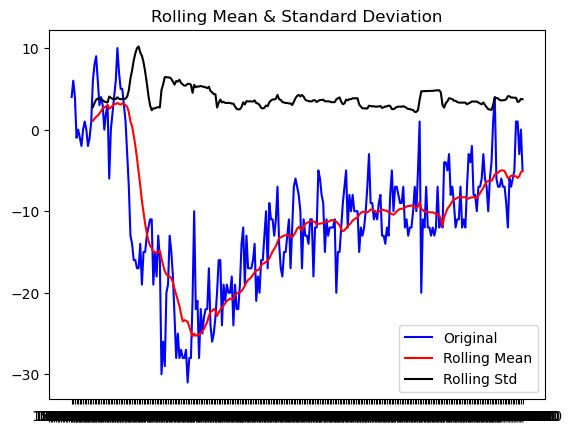

Results of Dickey-Fuller Test:
Test Statistic                  -2.146270
p-value                          0.226320
#Lags Used                      16.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64
parks_percent_change_from_baseline


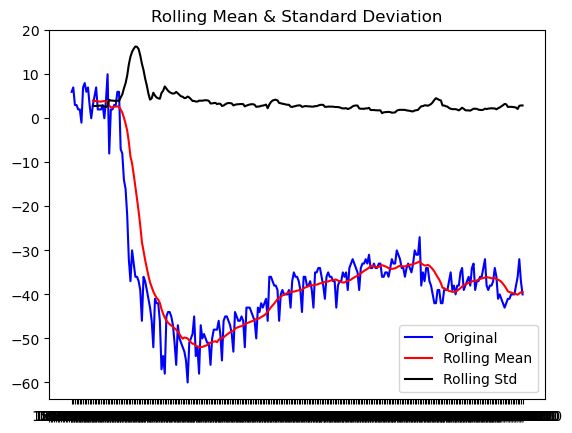

Results of Dickey-Fuller Test:
Test Statistic                  -3.543704
p-value                          0.006933
#Lags Used                      15.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64
transit_stations_percent_change_from_baseline


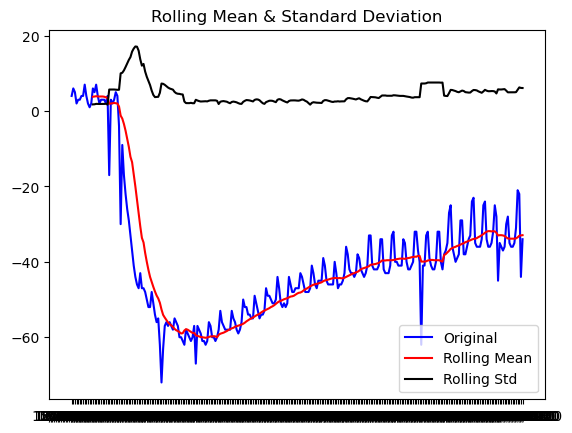

Results of Dickey-Fuller Test:
Test Statistic                  -3.588755
p-value                          0.005980
#Lags Used                      16.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64
workplaces_percent_change_from_baseline


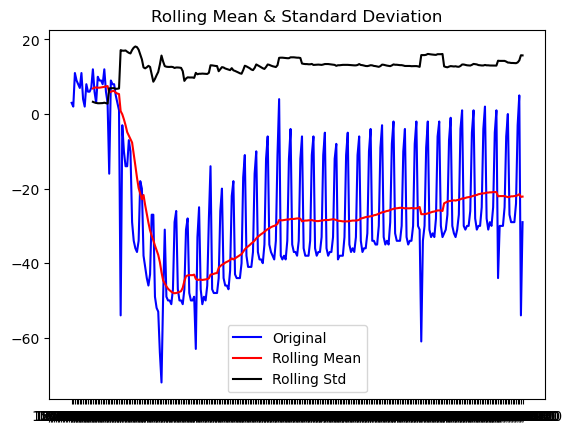

Results of Dickey-Fuller Test:
Test Statistic                  -3.284645
p-value                          0.015579
#Lags Used                      15.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64
residential_percent_change_from_baseline


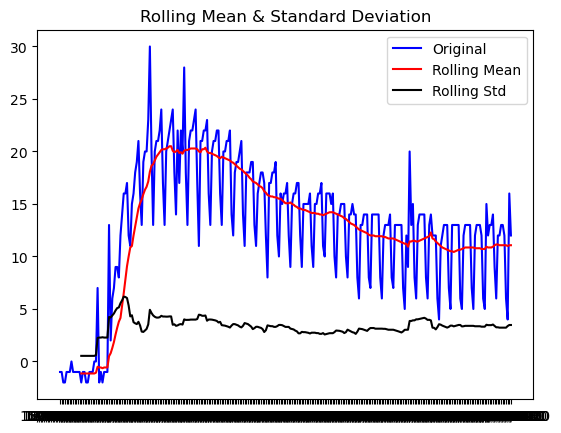

Results of Dickey-Fuller Test:
Test Statistic                  -3.161760
p-value                          0.022308
#Lags Used                      15.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64


In [20]:
for i in data.columns:
    if i != 'sub_region_1':
        print(i)
        test_stationarity(data[i])

retail_and_recreation_percent_change_from_baseline


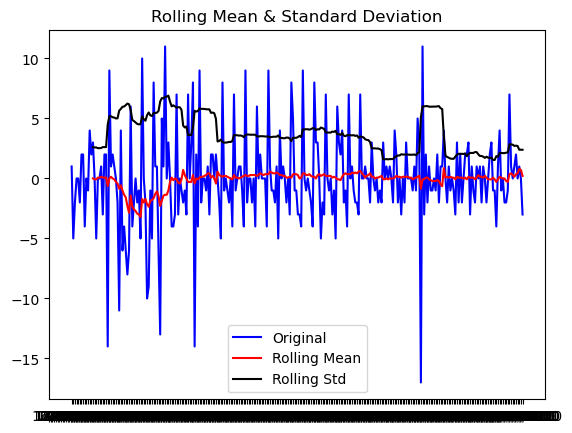

Results of Dickey-Fuller Test:
Test Statistic                  -2.069556
p-value                          0.256931
#Lags Used                      16.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64
grocery_and_pharmacy_percent_change_from_baseline


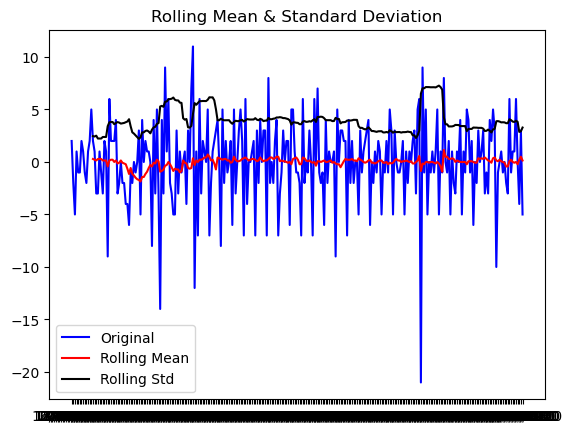

Results of Dickey-Fuller Test:
Test Statistic                  -3.558368
p-value                          0.006609
#Lags Used                      16.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64
parks_percent_change_from_baseline


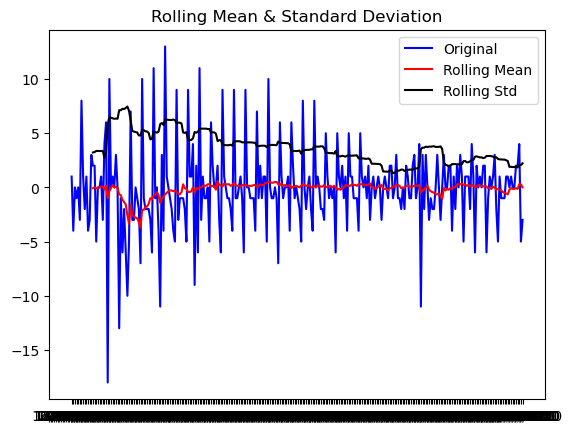

Results of Dickey-Fuller Test:
Test Statistic                  -3.176393
p-value                          0.021392
#Lags Used                      14.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64
transit_stations_percent_change_from_baseline


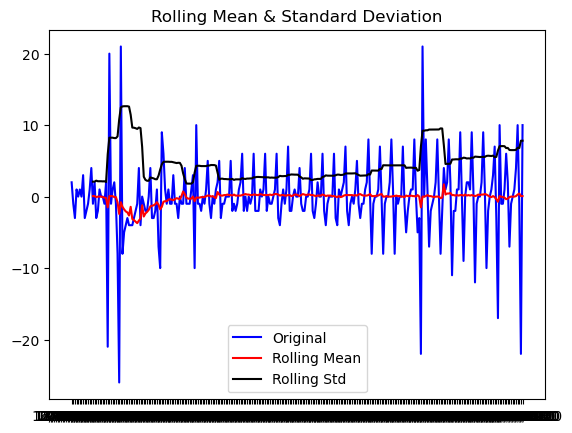

Results of Dickey-Fuller Test:
Test Statistic                  -2.702823
p-value                          0.073551
#Lags Used                      14.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64
workplaces_percent_change_from_baseline


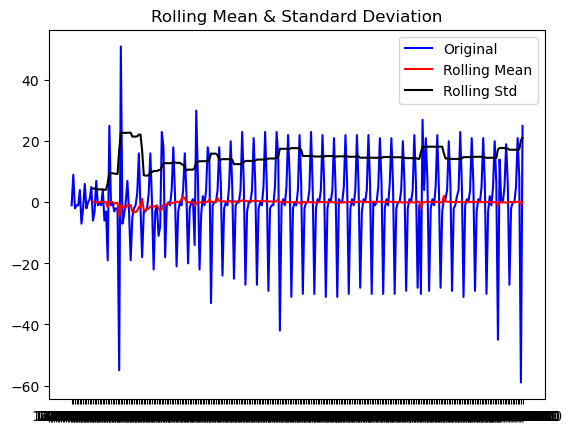

Results of Dickey-Fuller Test:
Test Statistic                  -3.140293
p-value                          0.023711
#Lags Used                      14.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64
residential_percent_change_from_baseline


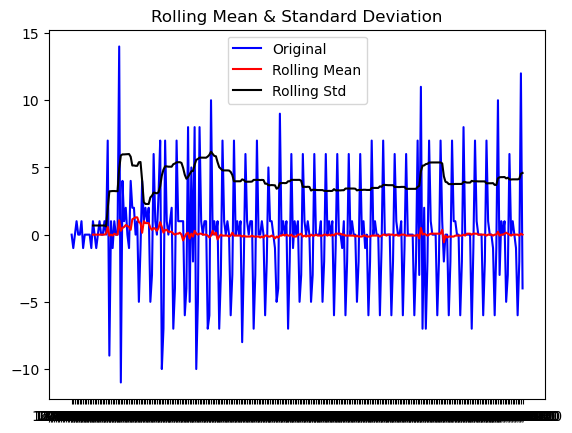

Results of Dickey-Fuller Test:
Test Statistic                  -2.974329
p-value                          0.037362
#Lags Used                      14.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64


In [21]:
for i in data.columns:
    if i != 'sub_region_1':
        print(i)
        factor=data[i]-data[i].shift()
        test_stationarity(factor.dropna())

**Stationary**
- retail_and_recreation_percent_change_from_baseline
- parks_percent_change_from_baseline
- transit_stations_percent_change_from_baseline
- workplaces_percent_change_from_baseline
- residential_percent_change_from_baseline

**Non-stationary**
- grocery_and_pharmacy_percent_change_from_baseline

### iii. Define 3 periods of time based on the observed characteristics and series data.

In [22]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import numpy as np

- retail_and_recreation_percent_change_from_baseline
    - 7, 14, 21
- grocery_and_pharmacy_percent_change_from_baseline
    - 14, 21, 7
- parks_percent_change_from_baseline
    - 7, 14, 21
- transit_stations_percent_change_from_baseline
    - 7, 14, 21
- workplaces_percent_change_from_baseline
    - 7, 14, 21
- residential_percent_change_from_baseline
    - 7, 14, 21

retail_and_recreation_percent_change_from_baseline


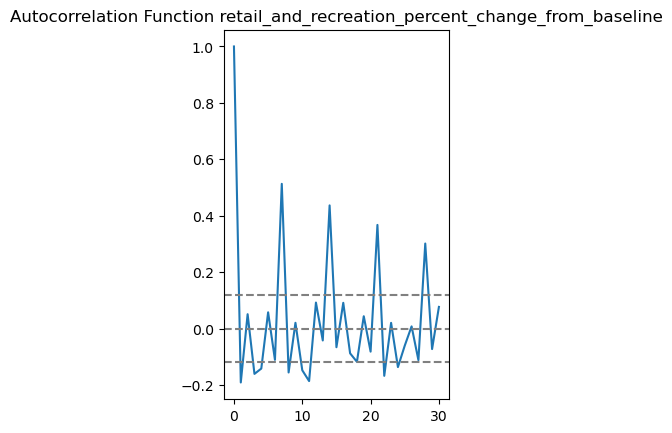

0   1.0
7   0.5130587480541436
14   0.4366320777185574
21   0.3674117075016377
28   0.30141691173903146
1   -0.19117525814028508
11   -0.1862174220523957
22   -0.16759828040239294
3   -0.1607385472641794
8   -0.15571728681310035
grocery_and_pharmacy_percent_change_from_baseline


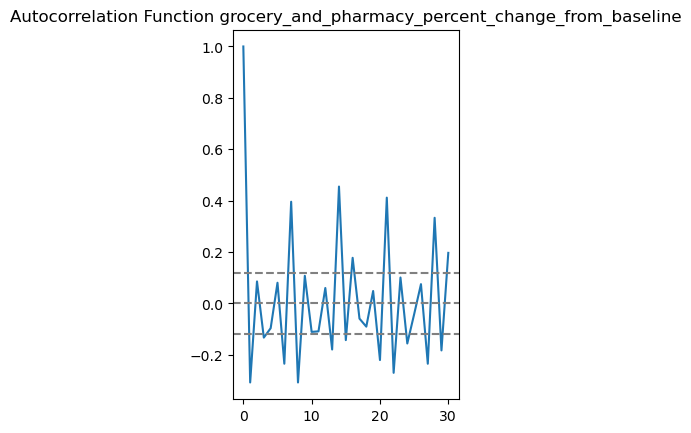

0   1.0
14   0.45499167561633536
21   0.4118478147231778
7   0.39593724954647436
28   0.3334308955311746
8   -0.30737203248776845
1   -0.3073626365829195
22   -0.26986363576395145
27   -0.2344643286551151
6   -0.2343902423611294
parks_percent_change_from_baseline


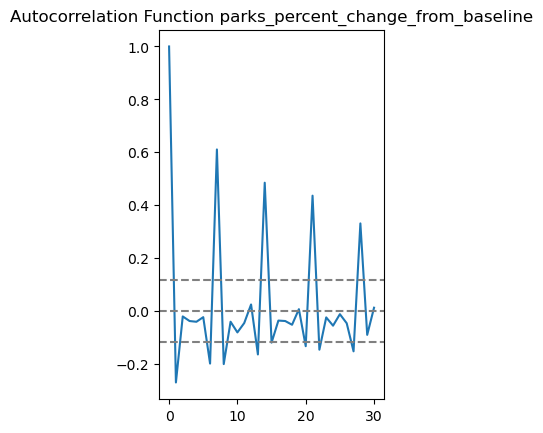

0   1.0
7   0.6105527288903716
14   0.48472210637528845
21   0.4357119025773626
28   0.33081713793199324
1   -0.2708385464453527
8   -0.20128173047515782
6   -0.19934940361998502
13   -0.1648247004198293
27   -0.15299441154391527
transit_stations_percent_change_from_baseline


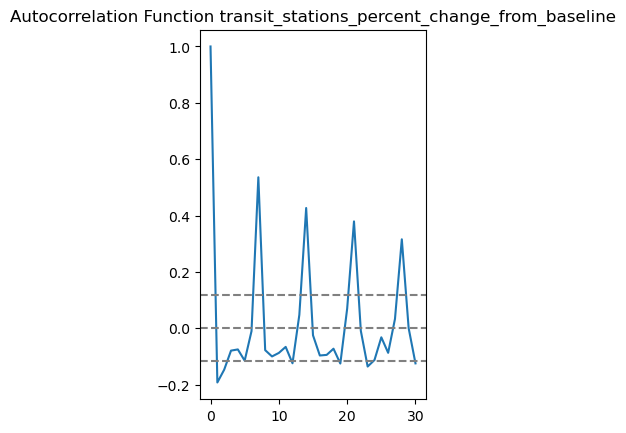

0   1.0
7   0.5357556947197812
14   0.42670002886823627
21   0.3791762105818203
28   0.3155946314696663
1   -0.19259754495096199
2   -0.14720160330662074
23   -0.1360464994539445
19   -0.12537195201767407
30   -0.12483189238244714
workplaces_percent_change_from_baseline


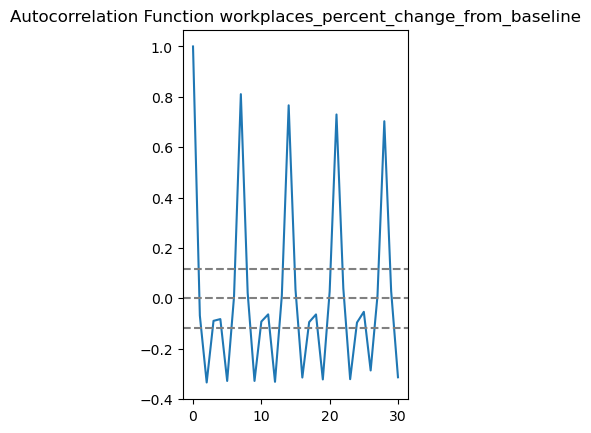

0   1.0
7   0.8106075399399602
14   0.7662443354473212
21   0.7298680728021798
28   0.7030758947353506
2   -0.334739415446857
12   -0.3320738120752987
5   -0.32868043823935017
9   -0.3285754793211743
19   -0.3226875876778807
residential_percent_change_from_baseline


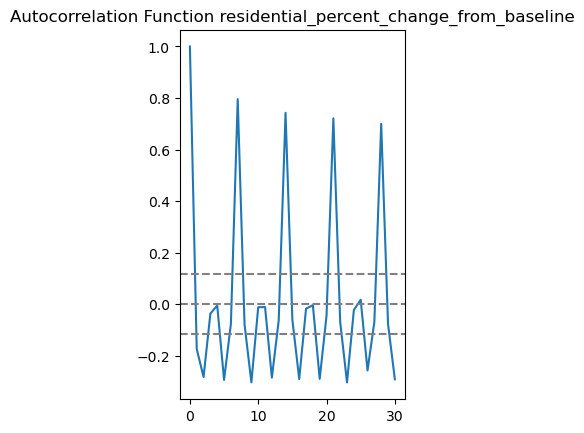

0   1.0
7   0.7954799954490583
14   0.7424400347783755
21   0.7210885076340073
28   0.6997261684470195
23   -0.30437071278252353
9   -0.30400179552228834
5   -0.29443442753494825
30   -0.29214336233335303
16   -0.29092112540177073


In [23]:
for i in data.columns:
    if i != 'sub_region_1':
        lags = len(data[i])-1
        print(i)
        factor_diff = data[i] - data[i].shift()
        factor_diff.dropna(inplace=True)
        lag_acf = acf(factor_diff, nlags=30)
        #lag_pacf = pacf(factor_diff, nlags=14, method='ols')
        # plot ACF
        plt.subplot(121)
        plt.plot(lag_acf)
        plt.axhline(y=0,linestyle='--',color='gray')
        plt.axhline(y=-1.96/np.sqrt(len(data[i])),linestyle='--',color='gray')
        plt.axhline(y=1.96/np.sqrt(len(data[i])),linestyle='--',color='gray')
        plt.title(f'Autocorrelation Function {i}')
        plt.show()
        
        k = abs(lag_acf).argsort()[::-1][:10]
        for i in k:
            print(f'{i}   {lag_acf[i]}')

# (5 pts) Build a model that predicts the last 7 days of the Workplaces indicator in Mexico.

### i. Do you need to make a transformation for generating the model?

In [24]:
work_data = data['workplaces_percent_change_from_baseline']

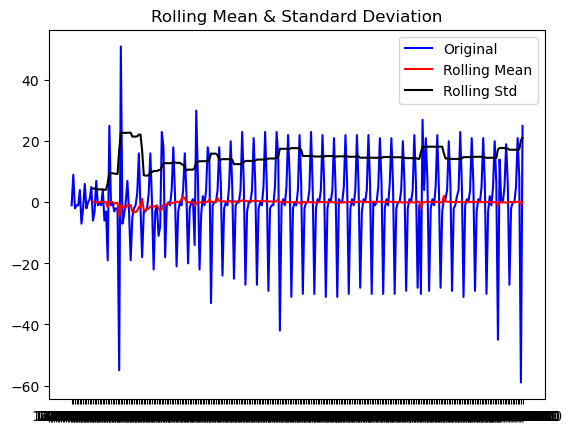

Results of Dickey-Fuller Test:
Test Statistic                  -3.140293
p-value                          0.023711
#Lags Used                      14.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64


In [25]:
work_data_diff = work_data - work_data.shift()
work_data_diff.dropna(inplace=True)
test_stationarity(work_data_diff)

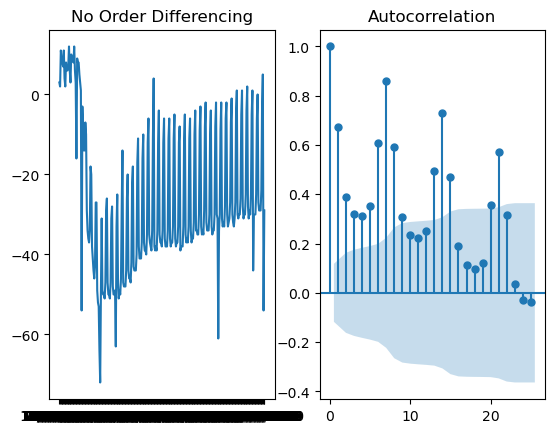

In [26]:
from statsmodels.graphics.tsaplots import plot_acf
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('No Order Differencing')
ax1.plot(work_data.dropna())

ax2 = f.add_subplot(122)
plot_acf(work_data.dropna(),ax=ax2)
plt.show()

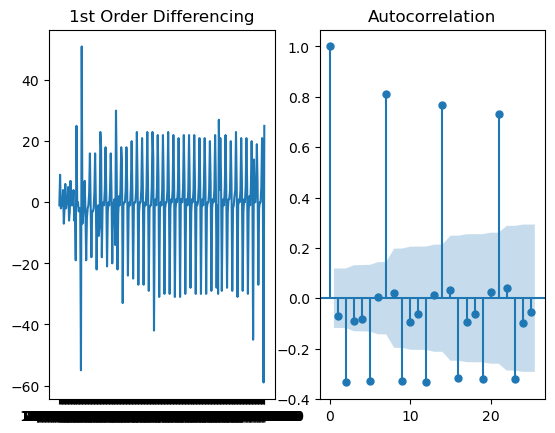

In [27]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(work_data.diff().dropna())

ax2 = f.add_subplot(122)
plot_acf(work_data.diff().dropna(),ax=ax2)
plt.show()


No need to make a transformation, as it appears to be stationary according to the tests

### ii. Train at least 3 predictive models.

### iv. Make a visualization of the best prediction.

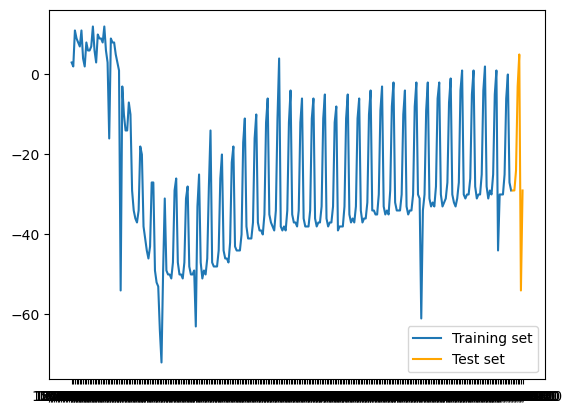

In [28]:
test_size = 7

train = work_data[:-test_size]
test = work_data[-test_size:]

train_diff = train - train.shift()
train_diff.dropna(inplace=True)

#plt.title('Airline passengers train and test sets', size=20)
plt.plot(train, label='Training set')
plt.plot(test, label='Test set', color='orange')
plt.legend();
plt.show()

#### MA 2

/Users/valeriaviridianapinedaromero/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/valeriaviridianapinedaromero/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/valeriaviridianapinedaromero/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/valeriaviridianapinedaromero/opt/anaconda3/lib/python3.8

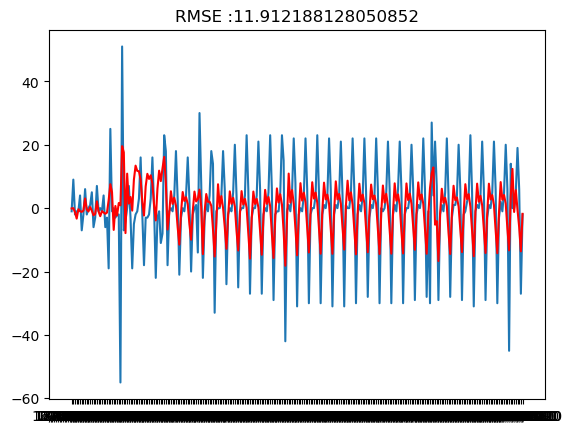

In [29]:
model = ARIMA(train,order=(0,1,2))
results_MA_2 = model.fit(disp=-1)
plt.plot(train_diff)
plt.plot(results_MA_2.fittedvalues,color='red')
plt.title(f'RMSE :{sqrt(mean_squared_error(train_diff, results_MA_2.fittedvalues))}')
plt.show()

predicted=-22.401099, expected=-29.000000
predicted=-26.915158, expected=-29.000000
predicted=-25.190942, expected=-24.000000
predicted=-23.460604, expected=-3.000000
predicted=-10.179747, expected=5.000000
predicted=-9.987744, expected=-54.000000
predicted=-47.861321, expected=-29.000000
Test RMSE: 20.671580006125257


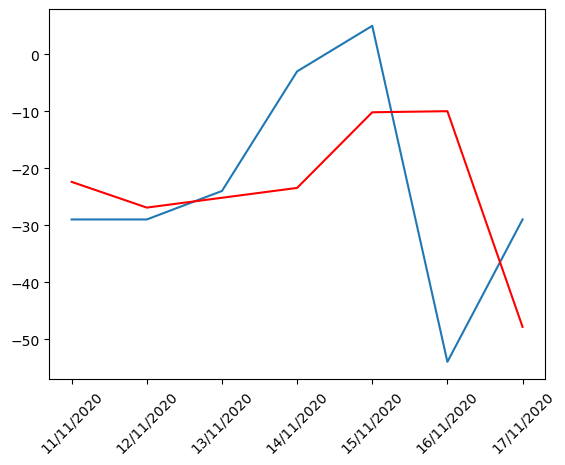

In [30]:
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse}')
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.xticks(rotation=45)
plt.show()

#### ARIMA 7,1,2

/Users/valeriaviridianapinedaromero/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/valeriaviridianapinedaromero/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/valeriaviridianapinedaromero/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/valeriaviridianapinedaromero/opt/anaconda3/lib/python3.8

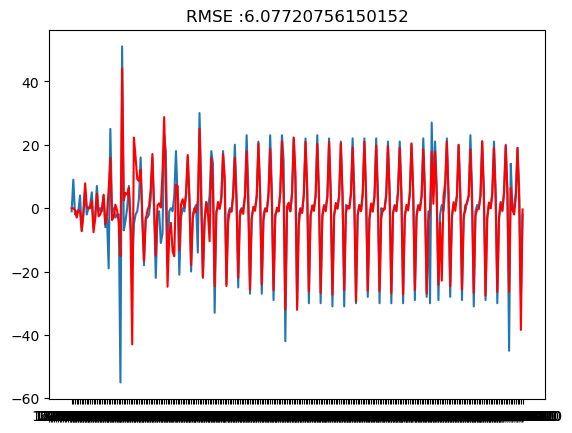

In [31]:
model = ARIMA(train,order=(7,1,2))
results_ARIMA_2 = model.fit(disp=-1)
plt.plot(train_diff)
plt.plot(results_ARIMA_2.fittedvalues,color='red')
plt.title(f'RMSE :{sqrt(mean_squared_error(train_diff, results_ARIMA_2.fittedvalues))}')
plt.show()

predicted=-26.506773, expected=-29.000000
predicted=-28.236842, expected=-29.000000
predicted=-23.925057, expected=-24.000000
predicted=-6.219159, expected=-3.000000
predicted=-0.625219, expected=5.000000
predicted=-21.574290, expected=-54.000000
predicted=-38.256687, expected=-29.000000
Test RMSE: 13.016051762618176


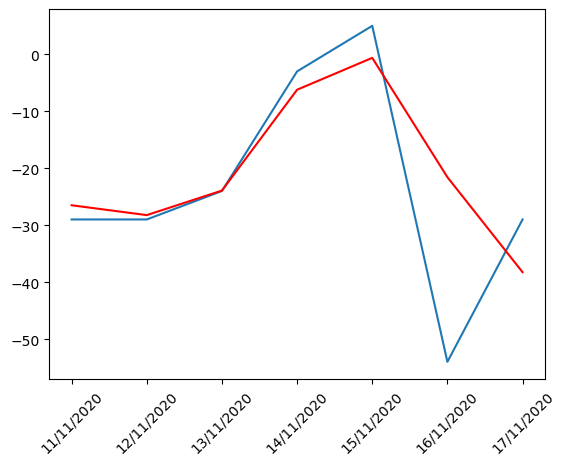

In [32]:
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(7,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse}')
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.xticks(rotation=45)
plt.show()

#### AR 7

/Users/valeriaviridianapinedaromero/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/valeriaviridianapinedaromero/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/valeriaviridianapinedaromero/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/valeriaviridianapinedaromero/opt/anaconda3/lib/python3.8

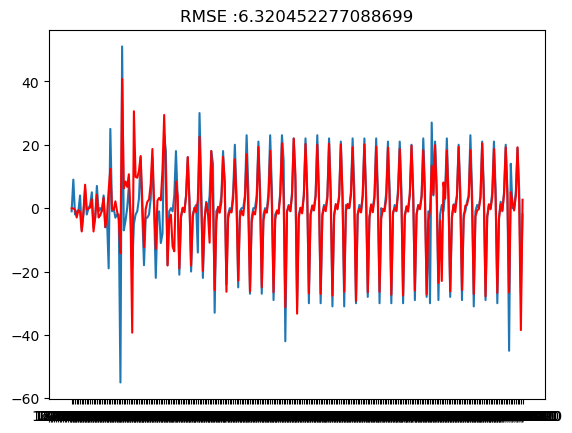

In [33]:
model = ARIMA(train,order=(7,1,0))
results_AR_7 = model.fit(disp=-1)
plt.plot(train_diff)
plt.plot(results_AR_7.fittedvalues,color='red')
plt.title(f'RMSE :{sqrt(mean_squared_error(train_diff, results_AR_7.fittedvalues))}')
plt.show()


predicted=-29.251466, expected=-29.000000
predicted=-29.778320, expected=-29.000000
predicted=-25.137514, expected=-24.000000
predicted=-7.134351, expected=-3.000000
predicted=-1.348889, expected=5.000000
predicted=-21.934524, expected=-54.000000
predicted=-42.334468, expected=-29.000000
Test RMSE: 13.444951077031922


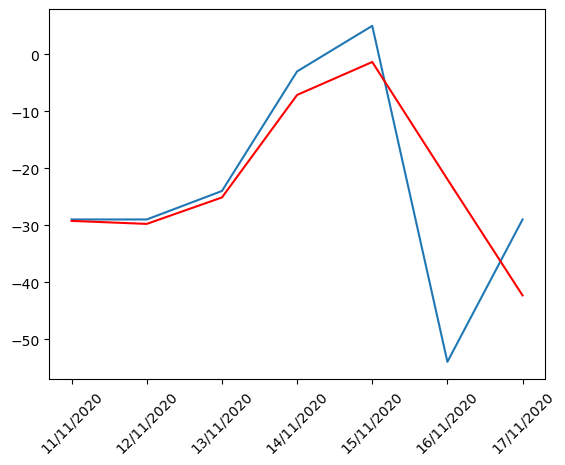

In [34]:
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(7,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse}')
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.xticks(rotation=45)
plt.show()

# d. (5 pts) Which states have a similar behavior in the Workplaces indicator?

### i. Document the characteristics of the algorithm you used.

### ii. How many groups you found?

### iii. Make a visualization of the grouped states.

In [35]:
State = ['Aguascalientes',
 'Baja California',
 'Baja California Sur',
 'Campeche',
 'Chiapas',
 'Chihuahua',
 'Coahuila',
 'Colima',
 'Durango',
 'Guanajuato',
 'Guerrero',
 'Hidalgo',
 'Jalisco',
 'Mexico City',
 'Michoacán',
 'Morelos',
 'Nayarit',
 'Nuevo Leon',
 'Oaxaca',
 'Puebla',
 'Querétaro',
 'Quintana Roo',
 'San Luis Potosi',
 'Sinaloa',
 'Sonora',
 'State of Mexico',
 'Tabasco',
 'Tamaulipas',
 'Tlaxcala',
 'Veracruz',
 'Yucatan',
 'Zacatecas']

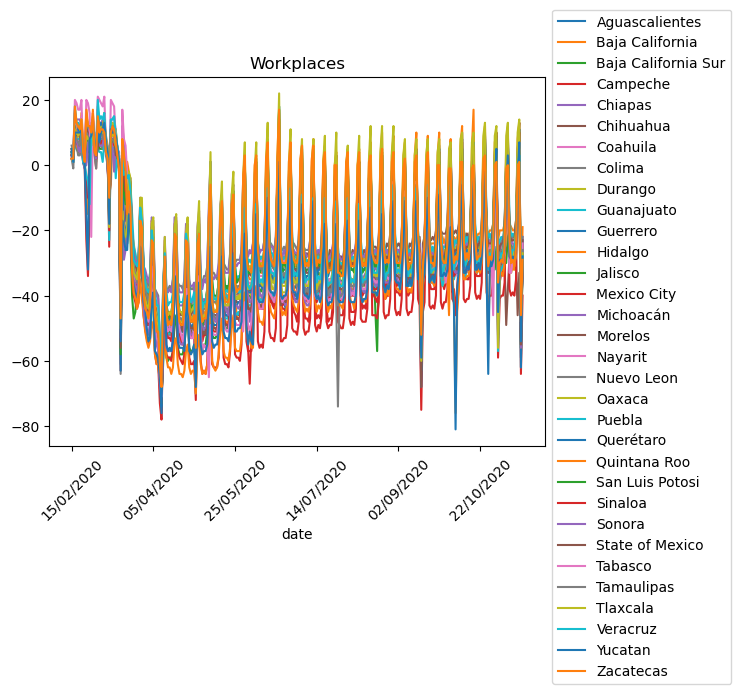

In [36]:
timeSeries = pd.DataFrame()
for i in State:
    data = series[series['sub_region_1']==i]
    data['workplaces_percent_change_from_baseline'].plot(label=i)
    timeSeries = timeSeries.append(data['workplaces_percent_change_from_baseline'])
pyplot.xticks(rotation=45)
pyplot.legend(bbox_to_anchor = (1, 1.2))
pyplot.title('Workplaces')
pyplot.show()
timeSeries.index = State

In [37]:
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import dendrogram, linkage

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)
    
    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

### Ward's method

In [38]:
Z = hac.linkage(timeSeries, method='ward',optimal_ordering=True)

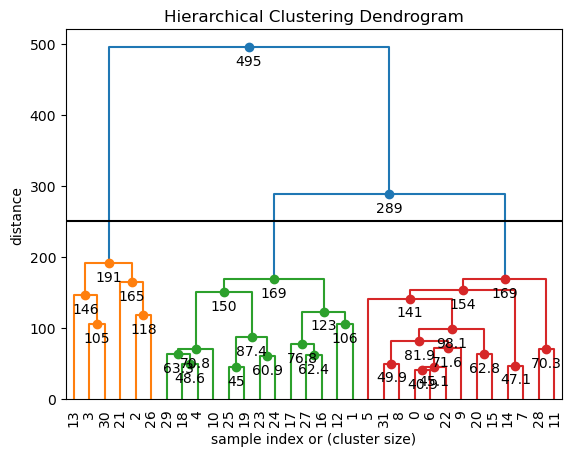

In [39]:
# set cut-off to 80
max_d = 250  # max_d as in max_distance

fancy_dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    max_d=max_d
)

plt.show()

### Pearson Correlation

In [40]:
# Clustering with Linkage
Z_pearson_correlation = hac.linkage(timeSeries, method='single', metric='correlation', optimal_ordering=True)

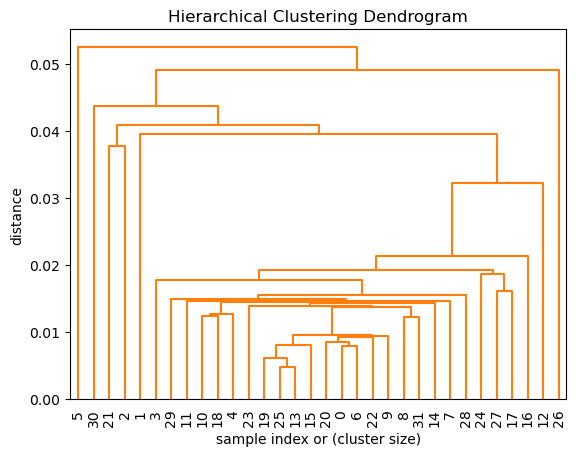

In [41]:
fancy_dendrogram(
    Z_pearson_correlation,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    max_d=max_d
)

plt.show()

### Spearman Correlation

In [42]:
# Here we use spearman correlation
def my_metric(x, y):
    r = stats.spearmanr(x, y)[0]
    return 1 - r # correlation to distance: range 0 to 2 # IF THE CLUSTERS ARE THE SAME THE DISTANCE WILL BE 0

# Do the clustering    
Z_spearman_correlation = hac.linkage(timeSeries,  method='single', metric=my_metric, optimal_ordering=True)

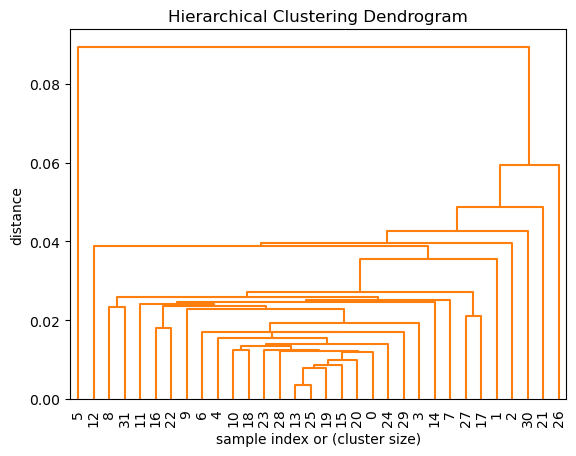

In [43]:
fancy_dendrogram(
    Z_spearman_correlation,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    max_d=max_d
)

plt.show()

### Dynamic Time Warpping

In [44]:
# Example of DTW
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Here we use dtw as distance metric
def dtw(x, y):
    distance, path = fastdtw(x, y, dist=euclidean)
    return distance

# Do the clustering with DTW
Z_dtw = hac.linkage(timeSeries,  method='single', metric=dtw, optimal_ordering=True)

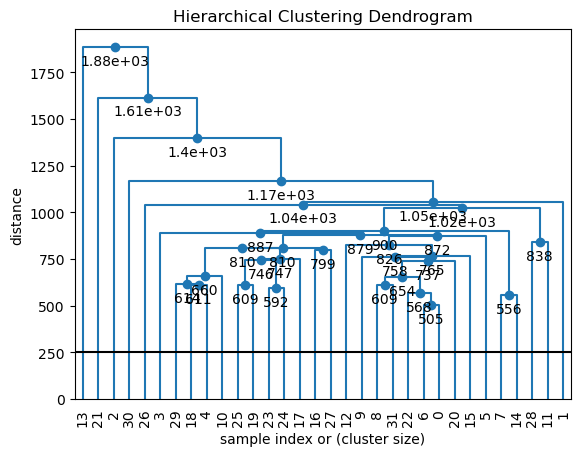

In [45]:
fancy_dendrogram(
    Z_dtw,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    max_d=max_d
)

plt.show()

### Generating clusters with Ward's method

In [46]:
from scipy.cluster.hierarchy import fcluster


def print_clusters(ts, Z, k, plot=False):
    plt.figure(figsize=(5, 5))
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')
    print(results)

    # check the results
    s = pd.Series(results)
    clusters = s.unique()
    
    new_order = series.index.unique()
    ts = ts.T.reindex(new_order, axis=0)

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
            ts.iloc[:,cluster_indeces].plot()
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor = (1, 1))
        plt.show()

[3 2 1 1 2 3 3 3 3 3 2 3 2 1 3 3 2 2 2 2 3 1 3 2 2 2 1 2 3 2 1 3]
Cluster 3 number of entries 13


<Figure size 500x500 with 0 Axes>

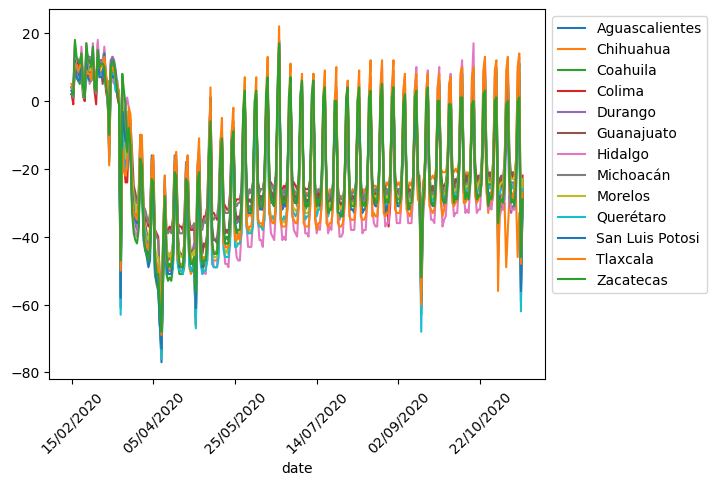

Cluster 2 number of entries 13


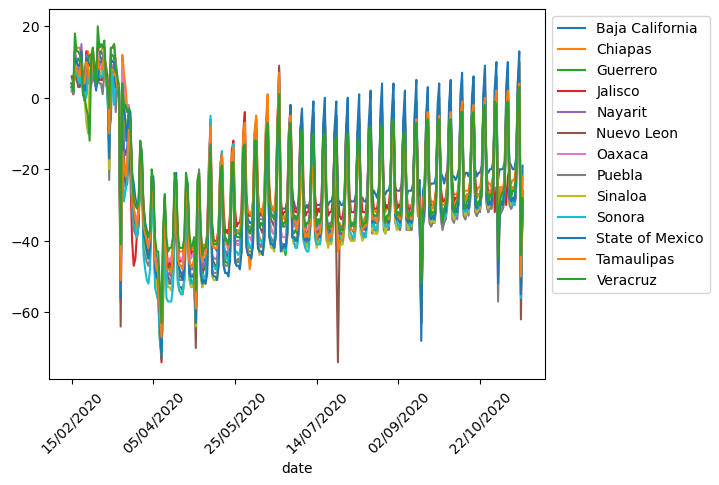

Cluster 1 number of entries 6


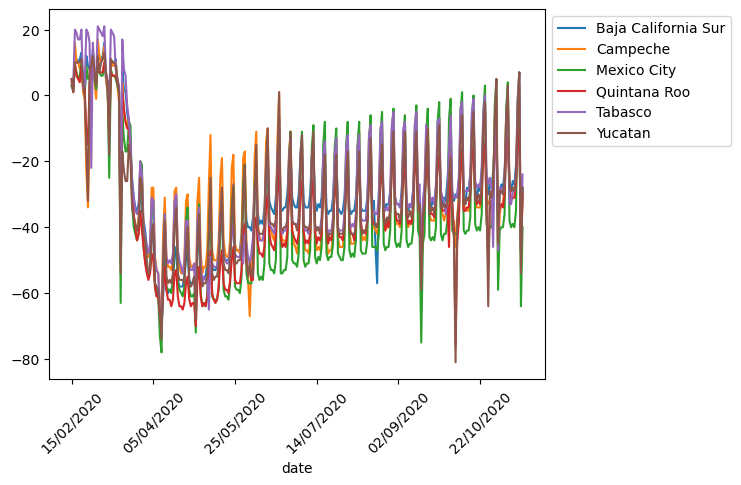

In [47]:
print_clusters(timeSeries, Z, 3, plot=True)